In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot

In [2]:
def length_to_windows(length_df, pops, window_size=100000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [3]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

In [4]:
for o in meta_data_samples.Origin.unique():
    f_length = len(meta_data_samples.loc[(meta_data_samples.Sex == "F") & (meta_data_samples.Origin == o)])
    all_length = len(meta_data_samples.loc[(meta_data_samples.Origin == o)])
    if f_length > 0:
        print(o, f_length, all_length, all_length/f_length)

Mikumi, Tanzania 13 38 2.923076923076923
Aberdare, Kenya 1 2 2.0
Chunga, Zambia 9 27 3.0
Awash, Ethiopia 1 2 2.0
Serengeti, Tanzania 7 14 2.0
Arusha, Tanzania 2 4 2.0
Ngorongoro, Tanzania 5 6 1.2
Ruaha, Tanzania 4 6 1.5
Gombe, Tanzania 10 17 1.7
Udzungwa, Tanzania 3 5 1.6666666666666667
Mahale, Tanzania 2 7 3.5
Selous, Tanzania 1 3 3.0
Lake Manyara, Tanzania 15 19 1.2666666666666666
Tarangire, Tanzania 4 7 1.75
Niokolo-Koba, Senegal 5 12 2.4
Issa Valley, Tanzania 1 1 1.0
Dendro Park, Zambia 3 4 1.3333333333333333
Filoha, Ethiopia 5 24 4.8
Gog Woreda, Gambella region, Ethiopia 8 25 3.125


In [5]:
pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

In [6]:
north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Kindae, Zambia': -1,
 'Papio, Senegal': 1,
 'Ursinus, Zambia': -1}

In [7]:
df_l = []
for chrom in ["chr{}".format(x) for x in (range(10, 15))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)

chr10
chr11
chr12
chr13
chr14
all_chrX
female_chrX


In [8]:
mean_hap_df = length_df.groupby(["individual", "chrom", "pos", "length"])[["n/s"]].mean().reset_index()
mean_hap_df = mean_hap_df.rename(columns={"pos": "start"})
mean_hap_df["windows"] = mean_hap_df.start
mean_hap_df["north"] = (mean_hap_df["n/s"]+1)/2

Conversion to contain weightings of the fragments.

In [9]:
x_df = mean_hap_df.loc[mean_hap_df.chrom.isin(["all_chrX"])]
autosomal_df = mean_hap_df.loc[~mean_hap_df.chrom.isin(["all_chrX", "female_chrX"])]

In [10]:
x_length = x_df.loc[x_df.individual == "PD_0199"].length.sum() # Just picking an individual for the sum
x_df["fragment_weight_x"] = x_df["n/s"]*x_df["length"]
percentage_north_x = ((x_df.groupby(by=["individual"])[["fragment_weight_x"]].sum()+x_length)/(2*x_length))
percentage_north_x.sort_values(by="fragment_weight_x", ascending=False)

/scratch/22385835/ipykernel_2512536/3124165879.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df["fragment_weight_x"] = x_df["n/s"]*x_df["length"]


,fragment_weight_x
individual,
PD_0728,0.999250
PD_0731,0.998814
PD_0724,0.998784
PD_0742,0.998714
PD_0744,0.998583
...,...
PD_0659,0.044394
PD_0237,0.044266
PD_0228,0.042074


In [11]:
autosomal_df["fragment_weight_aut"] = autosomal_df["n/s"]*autosomal_df["length"]
aut_length = autosomal_df.loc[autosomal_df.individual == "PD_0199"].length.sum()
percentage_north_aut = ((autosomal_df.groupby(by=["individual"])[["fragment_weight_aut"]].sum()+aut_length)/(2*aut_length))

/scratch/22385835/ipykernel_2512536/1998521393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autosomal_df["fragment_weight_aut"] = autosomal_df["n/s"]*autosomal_df["length"]


In [12]:
x_aut_percent = percentage_north_x.merge(right=percentage_north_aut, on="individual")
x_aut_percent["mean_percent"] = (x_aut_percent.fragment_weight_x+x_aut_percent.fragment_weight_aut)/2
sort_aut_x = x_aut_percent.sort_values(by="mean_percent", ascending=False).reset_index()
aut_sort = sort_aut_x[["individual", "fragment_weight_aut", "mean_percent"]]
aut_sort = aut_sort.rename(columns={"fragment_weight_aut": "North Percentage"})
aut_sort["chrom"] = "autosome"
x_sort = sort_aut_x[["individual", "fragment_weight_x", "mean_percent"]]
x_sort = x_sort.rename(columns={"fragment_weight_x": "North Percentage"})
x_sort["chrom"] = "chrX"
concat_df = pd.concat([aut_sort, x_sort])

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


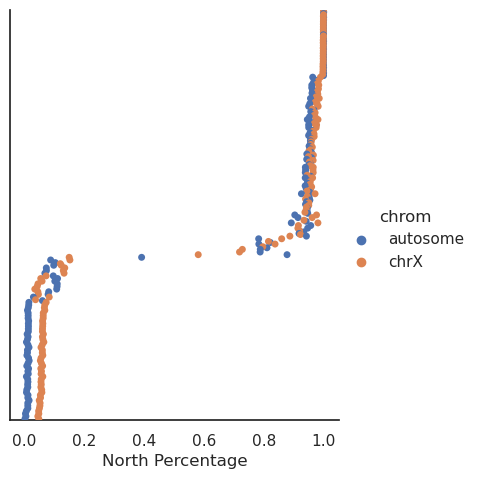

In [13]:
ax = sns.catplot(data=concat_df, x="North Percentage", y="individual", hue="chrom", kind="swarm", legend_out=False)
ax.set(yticks=[], ylabel=None)

Recombination check first

In [14]:
genetic_map = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/mikumi_pyrho_genetic_map_chr{}.txt"

In [15]:
mean_hap_df

,individual,chrom,start,length,n/s,windows,north
0,PD_0199,all_chrX,2500194,20174,1.0,2500194,1.0
1,PD_0199,all_chrX,2520368,18700,1.0,2520368,1.0
2,PD_0199,all_chrX,2539068,34526,1.0,2539068,1.0
3,PD_0199,all_chrX,2573594,1336,1.0,2573594,1.0
4,PD_0199,all_chrX,2574930,14436,1.0,2574930,1.0
...,...,...,...,...,...,...,...
5378219,Sci_30977,female_chrX,142482716,103397,1.0,142482716,1.0
5378220,Sci_30977,female_chrX,142586113,176169,1.0,142586113,1.0
5378221,Sci_30977,female_chrX,142762282,114048,1.0,142762282,1.0
5378222,Sci_30977,female_chrX,142876330,33956,1.0,142876330,1.0


In [16]:
chrX_recomb = pd.read_csv(genetic_map.format("X"), sep=" ")

In [17]:
chrX_test = mean_hap_df.loc[(mean_hap_df.individual == "PD_0199") & (mean_hap_df.chrom == "all_chrX")]

In [18]:
pos_mapping = {}
for i, row in chrX_test.iterrows():
    start = row.start
    end = row.length+start
    chr_subset = chrX_recomb.loc[(chrX_recomb.position >= start) & (chrX_recomb.position < end)]
    recomb = (chr_subset["Genetic_Map(cM)"].max()-chr_subset["Genetic_Map(cM)"].min())/(row.length)
    pos_mapping[start] = recomb

In [19]:
pos_mapping

{2500194: 1.2205767577430451e-06,
 2520368: 9.964401308008133e-07,
 2539068: 9.355781753731921e-07,
 2573594: 8.707936118094566e-07,
 2574930: 9.284551361818045e-07,
 2589366: 9.901737459974635e-07,
 2594587: 9.847502327690923e-07,
 2605650: 9.34655632161085e-07,
 2606655: 9.181425496876812e-07,
 2614334: 8.0892392927754e-07,
 2625868: 8.449415113159412e-07,
 2627246: 9.044591735963454e-07,
 2627490: 1.0082933051826117e-06,
 2635303: 1.012964161901503e-06,
 2642594: 1.0095745443842614e-06,
 2655410: 8.831877342882339e-07,
 2659055: 1.020085081176539e-06,
 2672266: 1.000937289476216e-06,
 2681617: 1.057964935575476e-06,
 2683842: 1.0531703640541404e-06,
 2689652: 1.0134327393486269e-06,
 2696778: 1.0140331796911667e-06,
 2702744: 9.502927728533071e-07,
 2719651: 8.923525101212202e-07,
 2729612: 1.0604167637966474e-06,
 2750947: 8.646413583075859e-07,
 2788223: 8.526204622861573e-07,
 2844330: 1.0025968153403805e-06,
 2870276: 9.865305501304258e-07,
 2935339: 1.138322831361401e-06,
 2952

In [20]:
chrX_df = mean_hap_df.loc[(mean_hap_df.chrom == "all_chrX")]
chrX_df["recomb"] =chrX_df.start.map(pos_mapping)

/scratch/22385835/ipykernel_2512536/964913148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrX_df["recomb"] =chrX_df.start.map(pos_mapping)


In [28]:
chrX_df["northern ancestry"] = (chrX_df["north"]+1)/2

/scratch/22385835/ipykernel_2512536/2164460134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrX_df["northern ancestry"] = (chrX_df["north"]+1)/2


In [29]:
bins = 5
chrX_df["recomb_group"] = pd.qcut(chrX_df["recomb"], bins, labels=False)

/scratch/22385835/ipykernel_2512536/4088054384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrX_df["recomb_group"] = pd.qcut(chrX_df["recomb"], bins, labels=False)


In [30]:
serengeti = meta_data_samples.loc[meta_data_samples.Origin == "Serengeti, Tanzania"].PGDP_ID

/scratch/22385835/ipykernel_2512536/3354264906.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.pointplot(data=df, y="northern ancestry", x="recomb_group", ci=95)


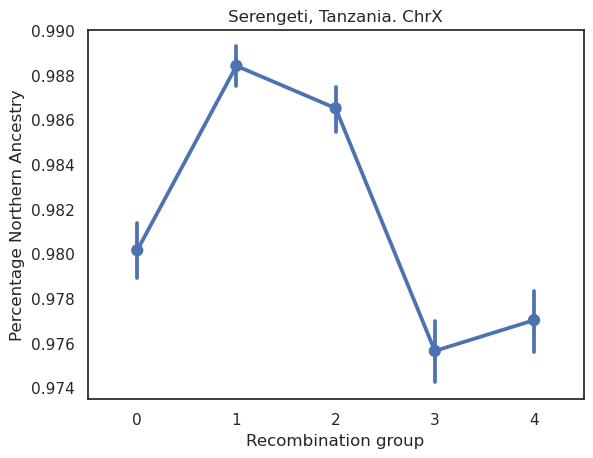

In [31]:
df = chrX_df.loc[chrX_df["individual"].isin(serengeti)]
g = sns.pointplot(data=df, y="northern ancestry", x="recomb_group", ci=95)
g.set(title="Serengeti, Tanzania. ChrX")
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")
plt.savefig("../figures/serengeti_chrX_recomb.png", dpi=300, bbox_inches='tight')

/scratch/22385835/ipykernel_2512536/3015568207.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.pointplot(data=df, y="northern ancestry", x="recomb_group", ci=95)


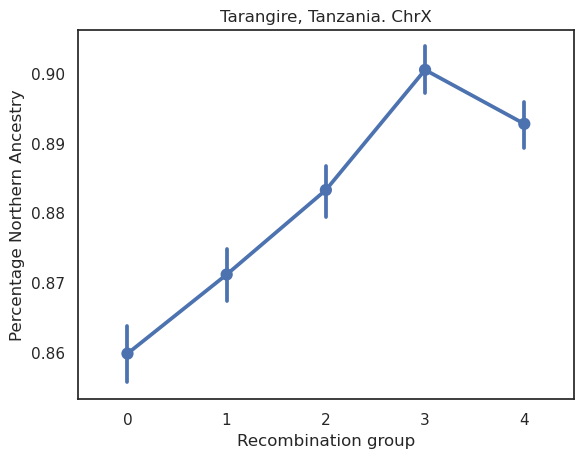

In [32]:
tarangire = meta_data_samples.loc[meta_data_samples.Origin == "Tarangire, Tanzania"].PGDP_ID
df = chrX_df.loc[chrX_df["individual"].isin(tarangire)]
g = sns.pointplot(data=df, y="northern ancestry", x="recomb_group", ci=95)
g.set(title="Tarangire, Tanzania. ChrX")
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")
plt.savefig("../figures/tarangirechrX_recomb.png", dpi=300, bbox_inches='tight')

/scratch/22385835/ipykernel_2512536/4074504795.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.pointplot(data=df, y="northern ancestry", x="recomb_group", ci=95)


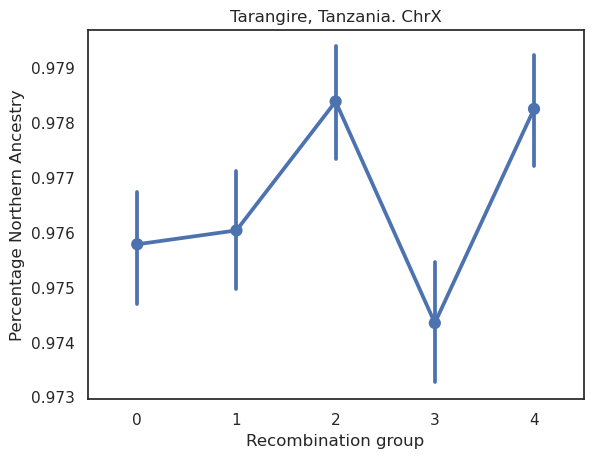

In [33]:
manyara = meta_data_samples.loc[meta_data_samples.Origin == "Lake Manyara, Tanzania"].PGDP_ID
df = chrX_df.loc[chrX_df["individual"].isin(manyara)]
g = sns.pointplot(data=df, y="northern ancestry", x="recomb_group", ci=95)
g.set(title="Tarangire, Tanzania. ChrX")
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")
plt.savefig("../figures/manyarachrX_recomb.png", dpi=300, bbox_inches='tight')

/scratch/22385835/ipykernel_2512536/1640090291.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.pointplot(data=df, y="northern ancestry", x="recomb_group", ci=95)


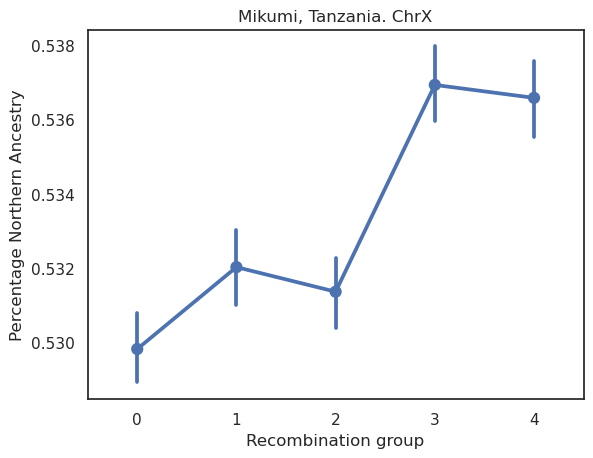

In [34]:
mikumi = meta_data_samples.loc[meta_data_samples.Origin == "Mikumi, Tanzania"].PGDP_ID
df = chrX_df.loc[chrX_df["individual"].isin(mikumi)]
g = sns.pointplot(data=df, y="northern ancestry", x="recomb_group", ci=95)
g.set(title="Mikumi, Tanzania. ChrX")
g.set(xlabel="Recombination group", ylabel="Percentage Northern Ancestry")
plt.savefig("../figures/mikumichrX_recomb.png", dpi=300, bbox_inches='tight')

Loading geneinfo

In [8]:
%env ftp_proxy http://proxy-default:3128
%env http_proxy http://proxy-default:3128
%env https_proxy http://proxy-default:3128

env: ftp_proxy=http://proxy-default:3128
env: http_proxy=http://proxy-default:3128
env: https_proxy=http://proxy-default:3128


In [9]:
import geneinfo as gi

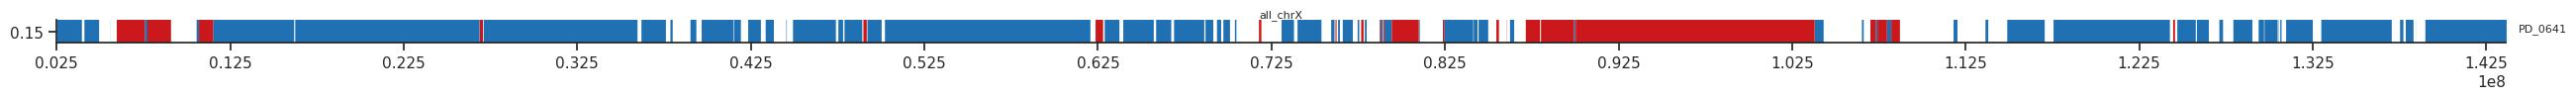

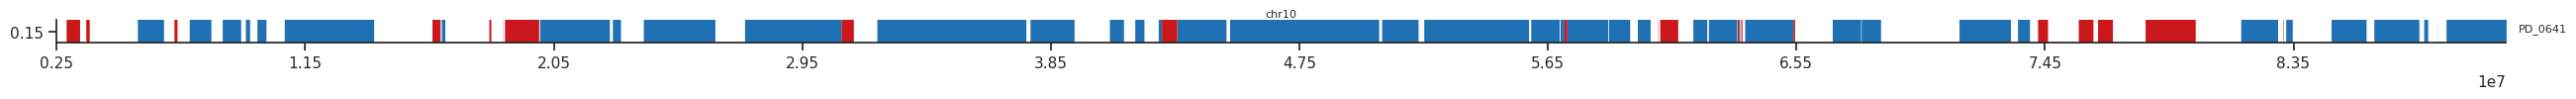

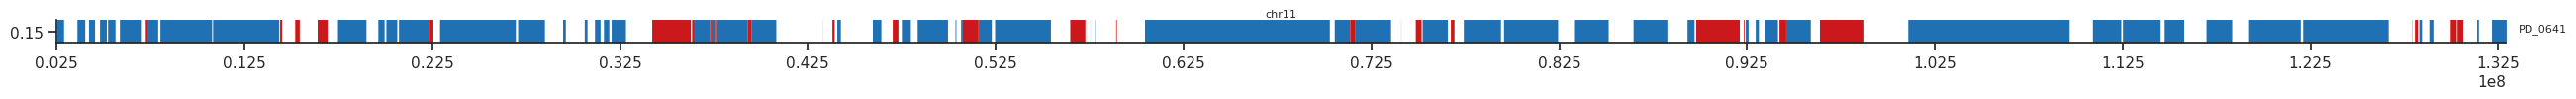

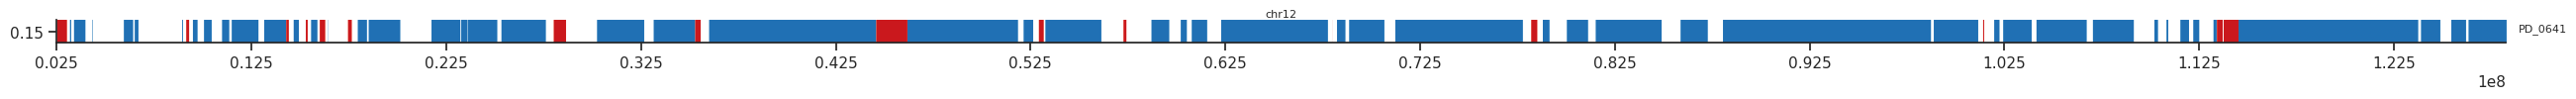

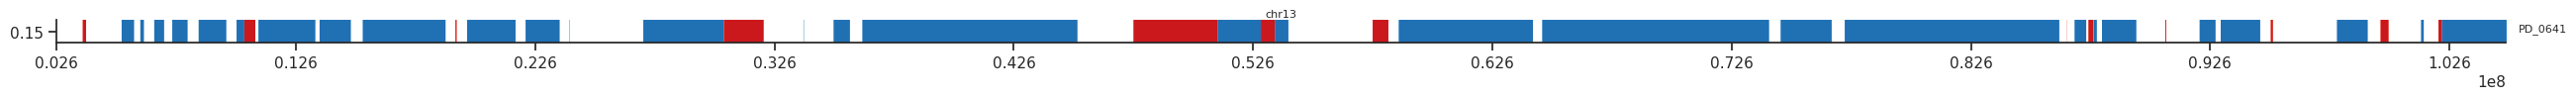

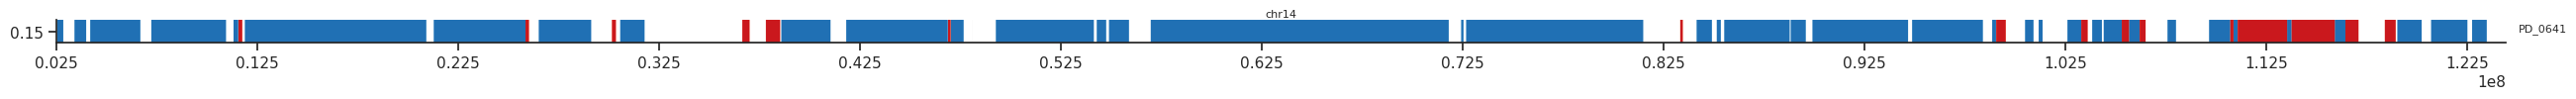

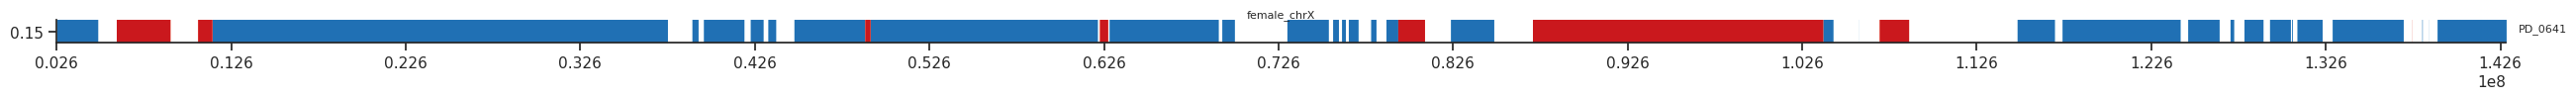

In [31]:
ind_test = mean_hap_df.loc[mean_hap_df.individual == "PD_0641"]
for c in ind_test.chrom.unique():
    c_sub = ind_test.loc[(ind_test.chrom == c) & (ind_test.windows >= 2500000)]
    fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

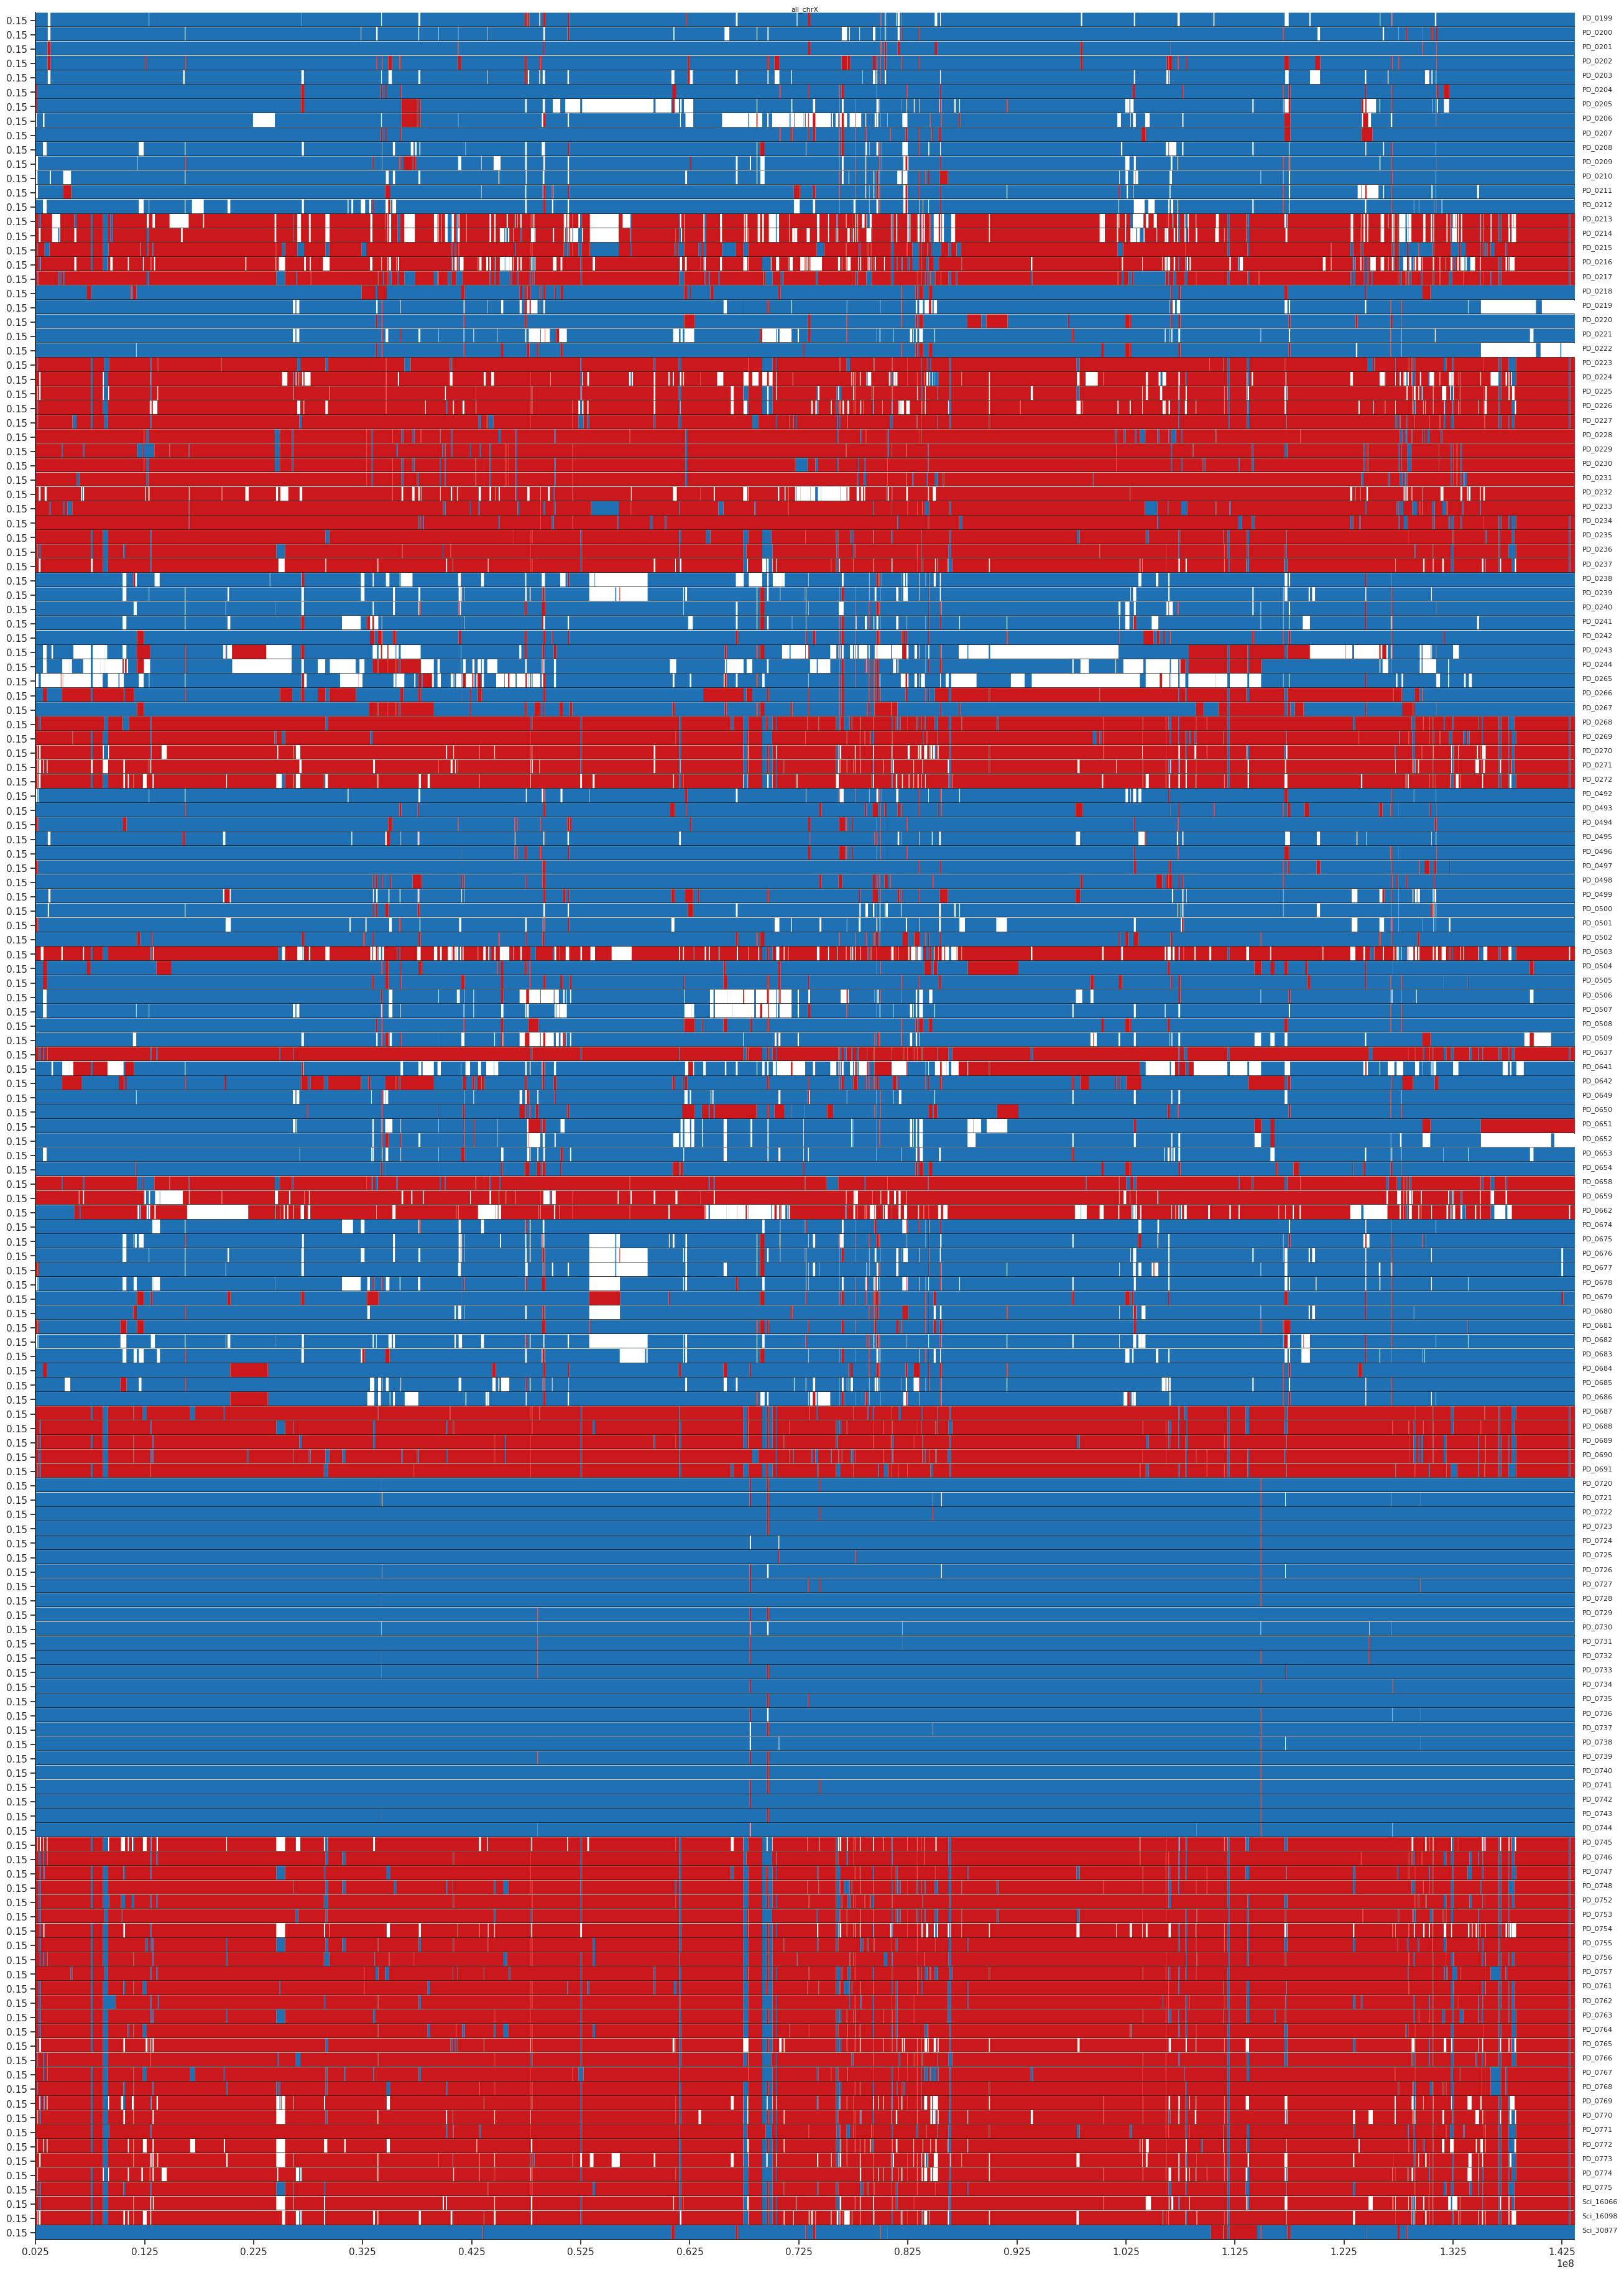

In [ ]:
c_sub = mean_hap_df.loc[mean_hap_df.chrom == "all_chrX"]
fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

In [52]:
meta_data_samples.loc[meta_data_samples.PGDP_ID == "PD_0266"]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
57,PD_0266,123,Knauf/Chuma/Roos,Papio,anubis,"Tarangire, Tanzania",M,"Tarangire, Dar es Salaam, Coastal Zone, 34588 ...",39.210736,-6.708198,57,"Anubis, Tanzania"


In [35]:
eastern_yellows = meta_data_samples.loc[meta_data_samples.C_origin == "Cynocephalus, Central Tanzania"].PGDP_ID

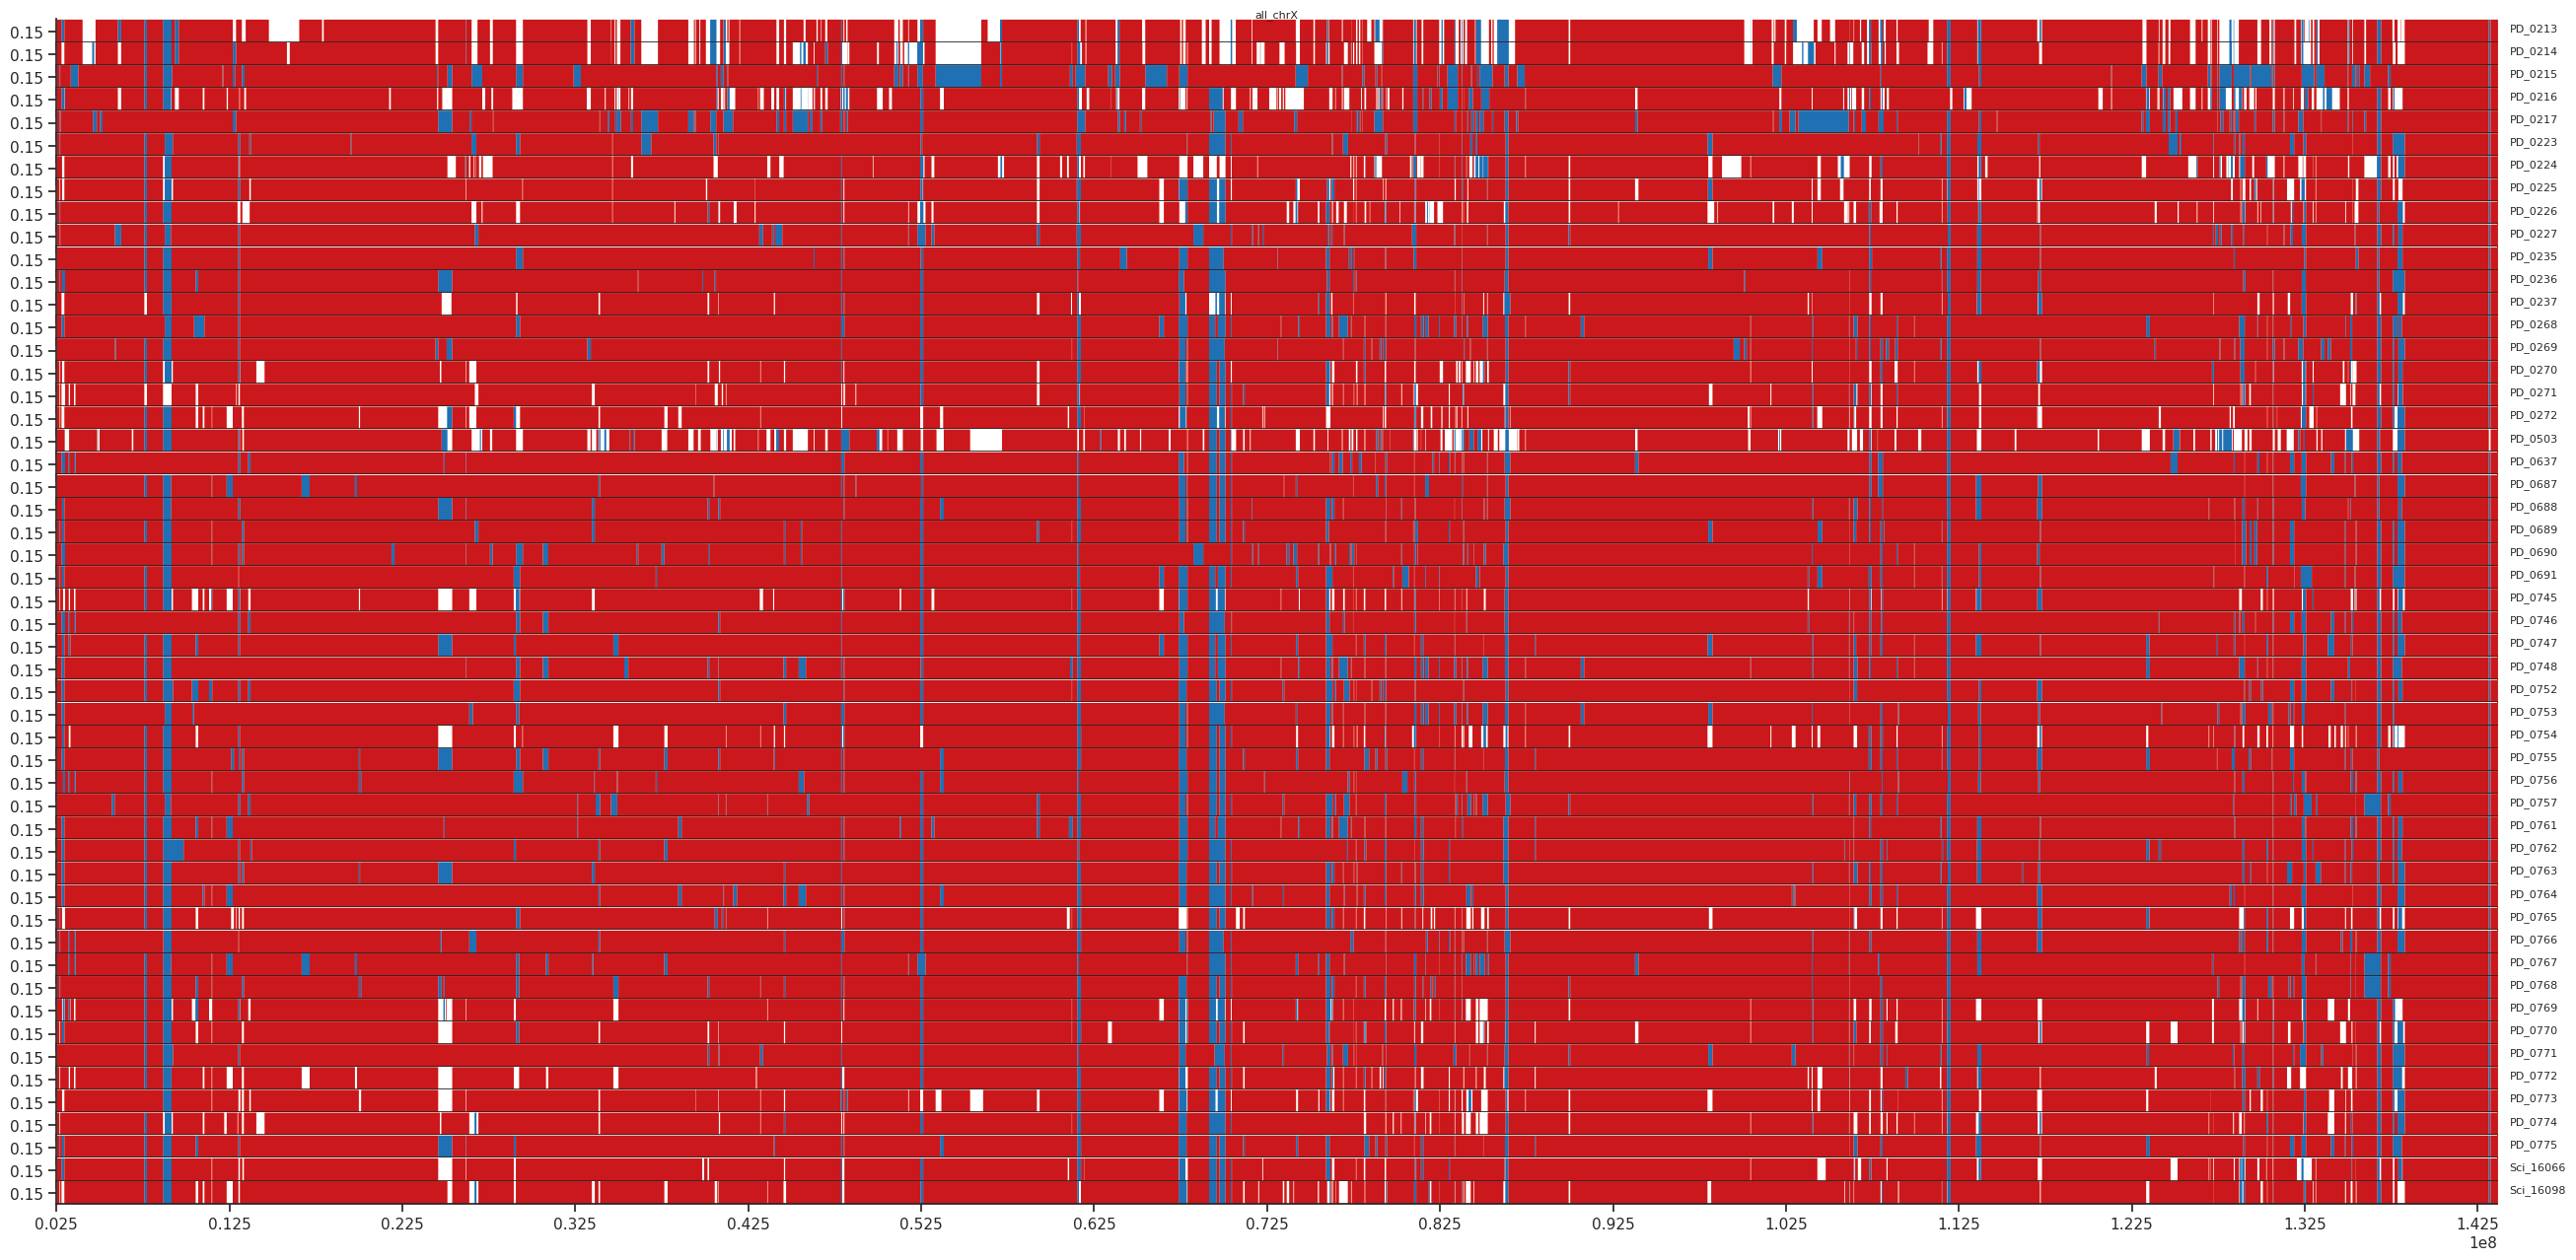

In [38]:
c_sub = mean_hap_df.loc[(mean_hap_df.chrom == "all_chrX") & (mean_hap_df.individual.isin(eastern_yellows))]
fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

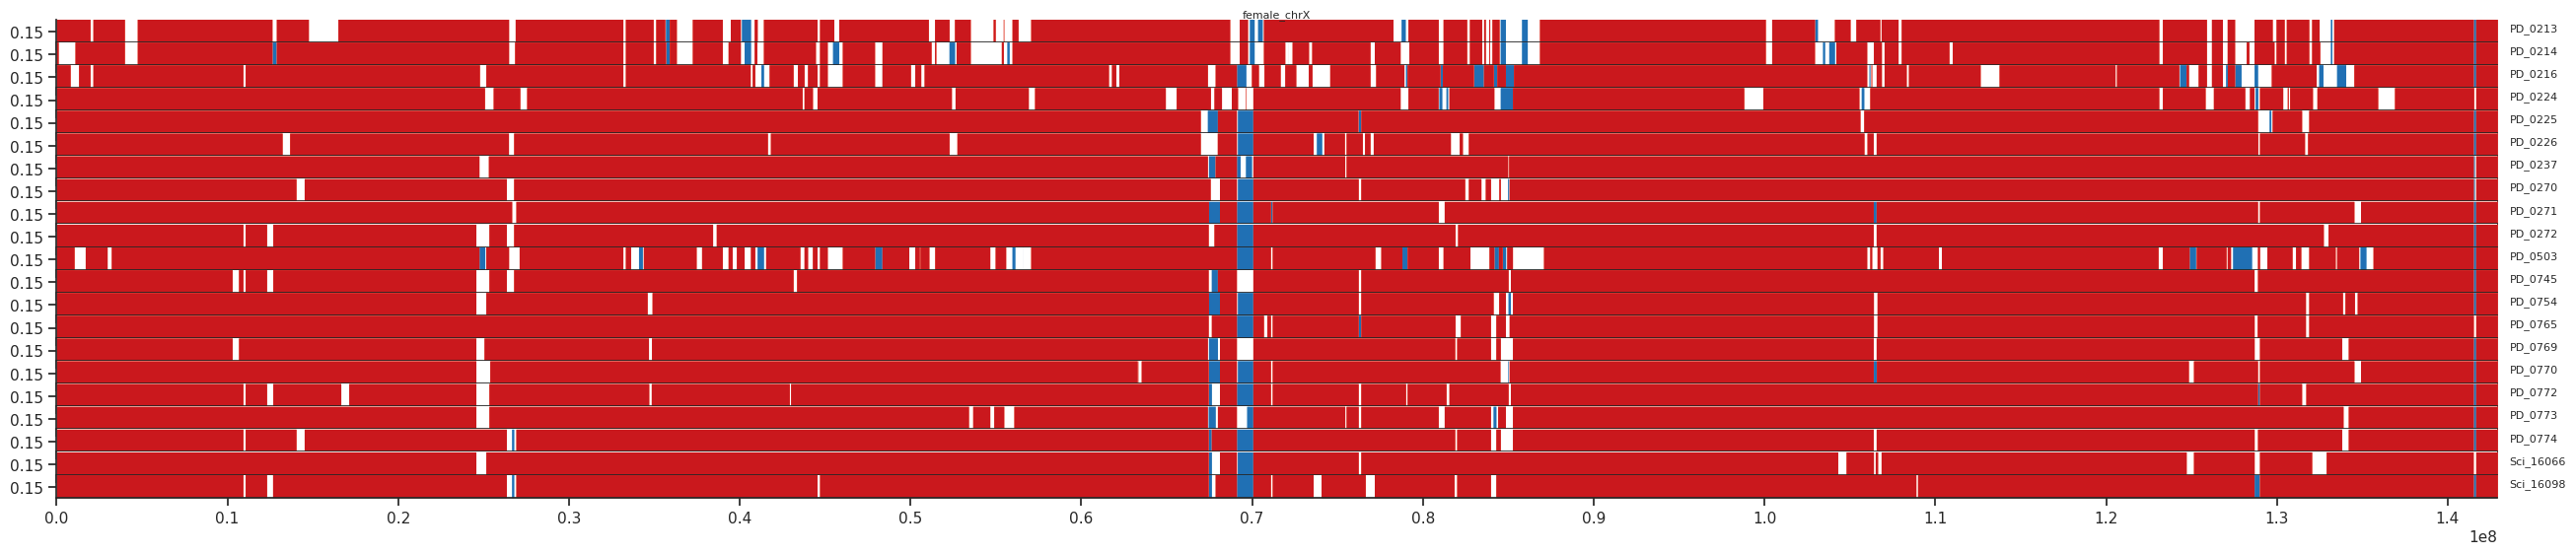

In [39]:
c_sub = mean_hap_df.loc[(mean_hap_df.chrom == "female_chrX") & (mean_hap_df.individual.isin(eastern_yellows))]
fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

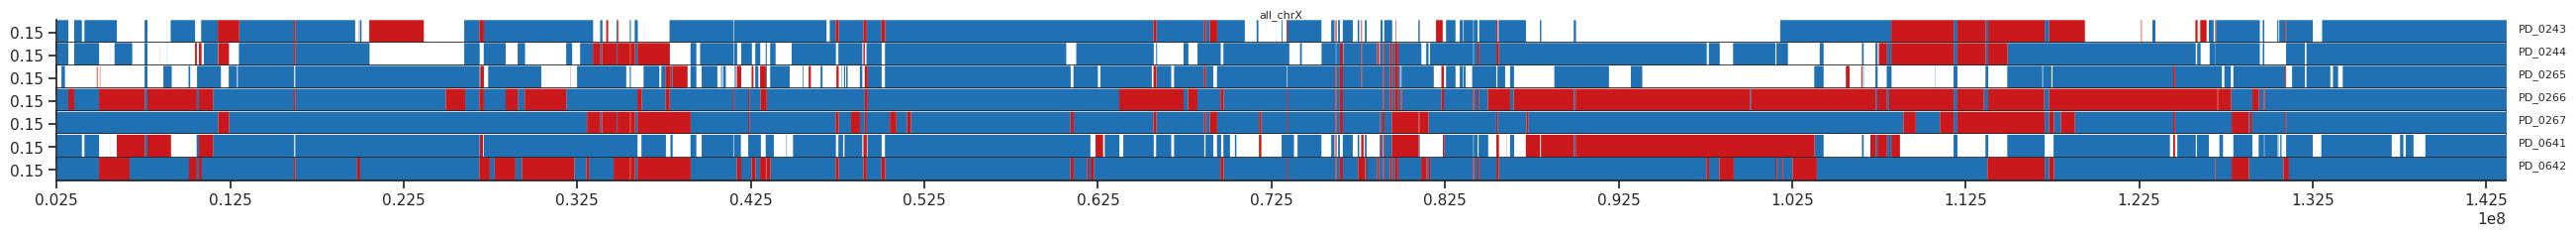

In [58]:
c_sub = mean_hap_df.loc[(mean_hap_df.chrom == "all_chrX") & (mean_hap_df.individual.isin(tarangire))]
fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

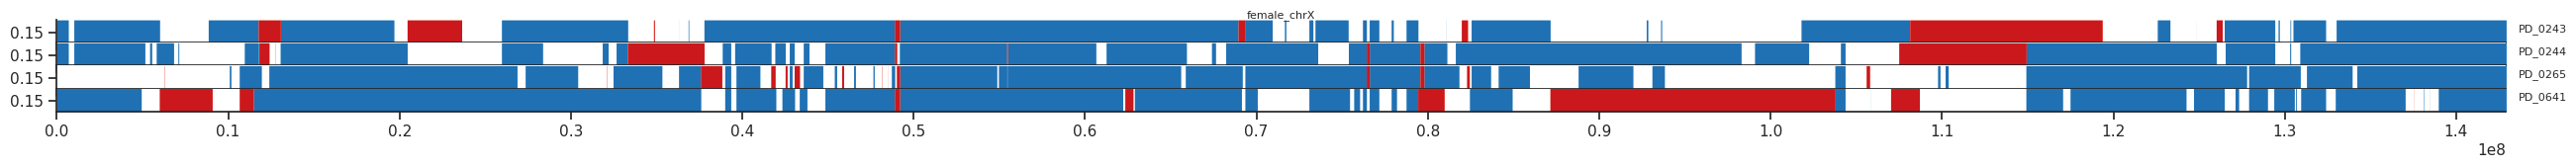

In [59]:
c_sub = mean_hap_df.loc[(mean_hap_df.chrom == "female_chrX") & (mean_hap_df.individual.isin(tarangire))]
fig = horizonplot(c_sub, 'north', width=2, col='chrom', row='individual', size=0.3, aspect=100)

In [46]:
mean_hap_df.loc[(mean_hap_df.chrom == "all_chrX") & (mean_hap_df.individual.isin(["PD_0686"]))]

,individual,chrom,start,length,n/s,windows,north
3333952,PD_0686,all_chrX,2500194,20174,1.0,2500194,1.0
3333953,PD_0686,all_chrX,2520368,18700,1.0,2520368,1.0
3333954,PD_0686,all_chrX,2539068,34526,1.0,2539068,1.0
3333955,PD_0686,all_chrX,2573594,1336,1.0,2573594,1.0
3333956,PD_0686,all_chrX,2574930,14436,1.0,2574930,1.0
...,...,...,...,...,...,...,...
3341235,PD_0686,all_chrX,143085438,4621,1.0,143085438,1.0
3341236,PD_0686,all_chrX,143090059,12501,1.0,143090059,1.0
3341237,PD_0686,all_chrX,143102560,124649,1.0,143102560,1.0
3341238,PD_0686,all_chrX,143227209,411301,1.0,143227209,1.0


Gene info

In [22]:
import sys, os
from collections import defaultdict
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set_style('white')

import geneinfo as gi
gi.email('your@email.com')

%env ftp_proxy http://proxy-default:3128
%env http_proxy http://proxy-default:3128
%env https_proxy http://proxy-default:3128

env: ftp_proxy=http://proxy-default:3128
env: http_proxy=http://proxy-default:3128
env: https_proxy=http://proxy-default:3128


In [26]:
mikumi = meta_data_samples.loc[meta_data_samples.Origin == "Mikumi, Tanzania"].PGDP_ID
mikumi_df = mean_hap_df.loc[mean_hap_df.individual.isin(mikumi)]

In [52]:
mikumi_ns = (mikumi_df.groupby(["start"])[["north"]].mean())

In [54]:
mikumi_ns.index

Index([       37,       175,       672,       702,       748,      1075,
           44669,     51491,     59088,     78383,
       ...
       142762282, 142876330, 142906007, 142910286, 143013680, 143085438,
       143090059, 143102560, 143227209, 143638510],
      dtype='int64', name='start', length=35448)

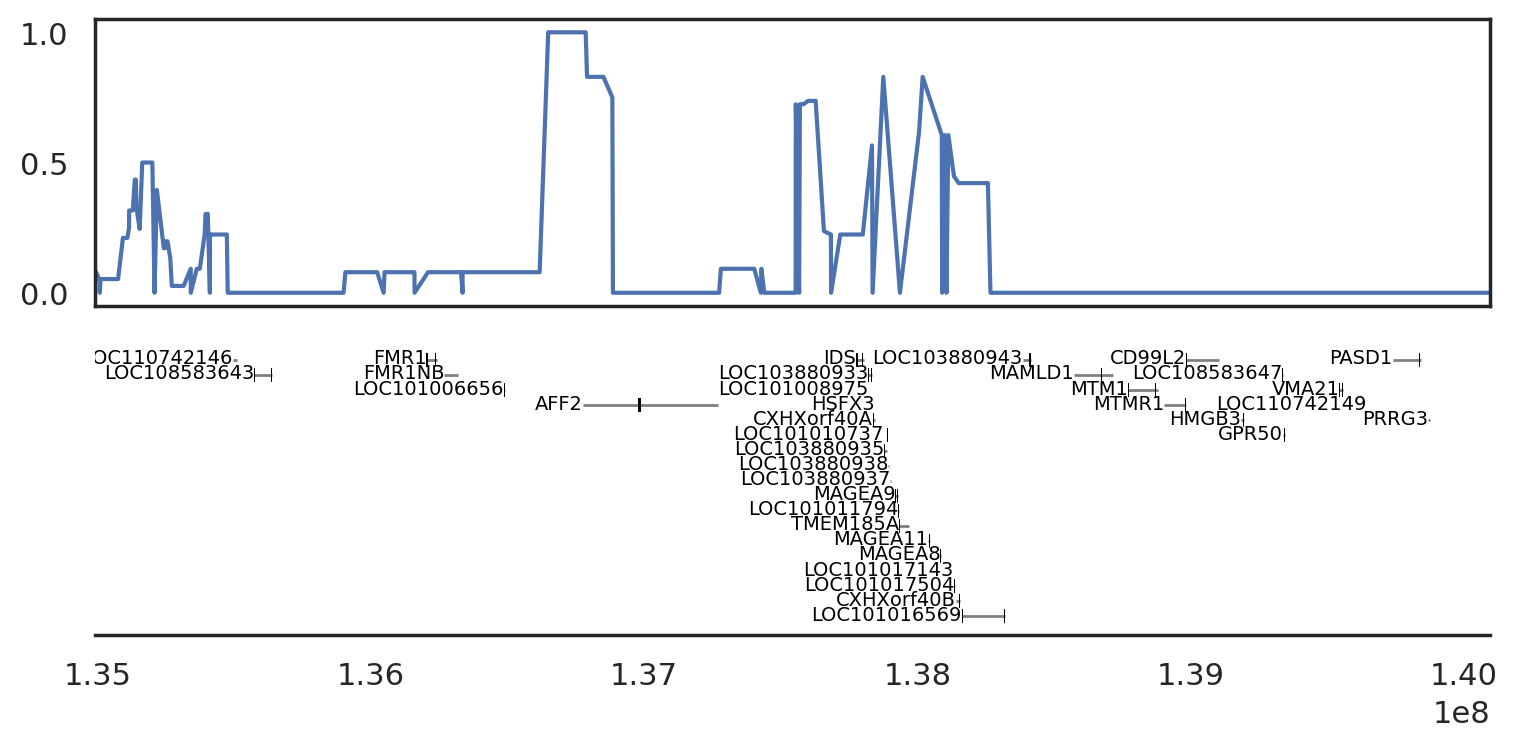

In [55]:
ax = gi.gene_plot('chrX', 135000000, 139877354, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(mikumi_ns.index, mikumi_ns.north)

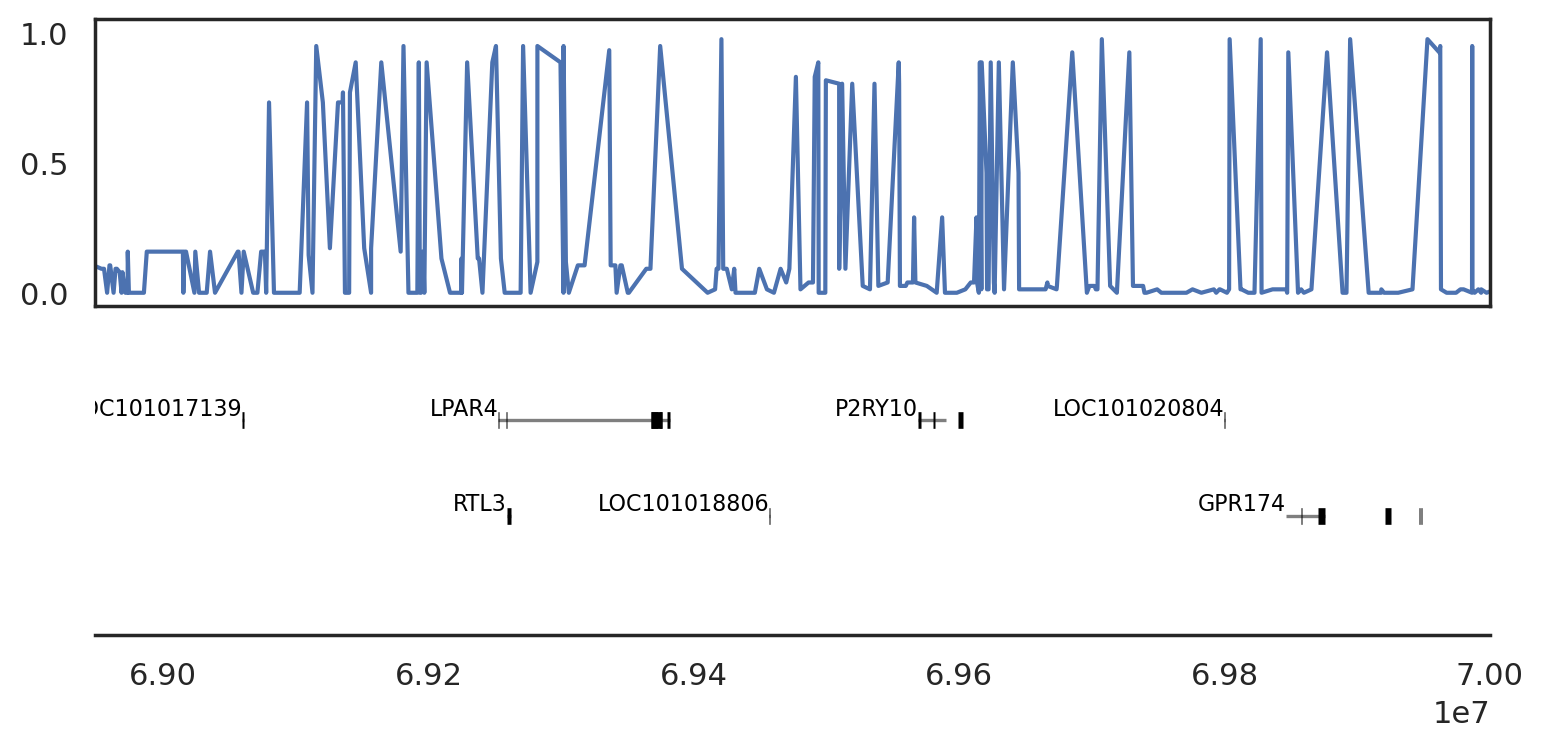

In [62]:
ax = gi.gene_plot('chrX', 69000000, 70000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(mikumi_ns.index, mikumi_ns.north)

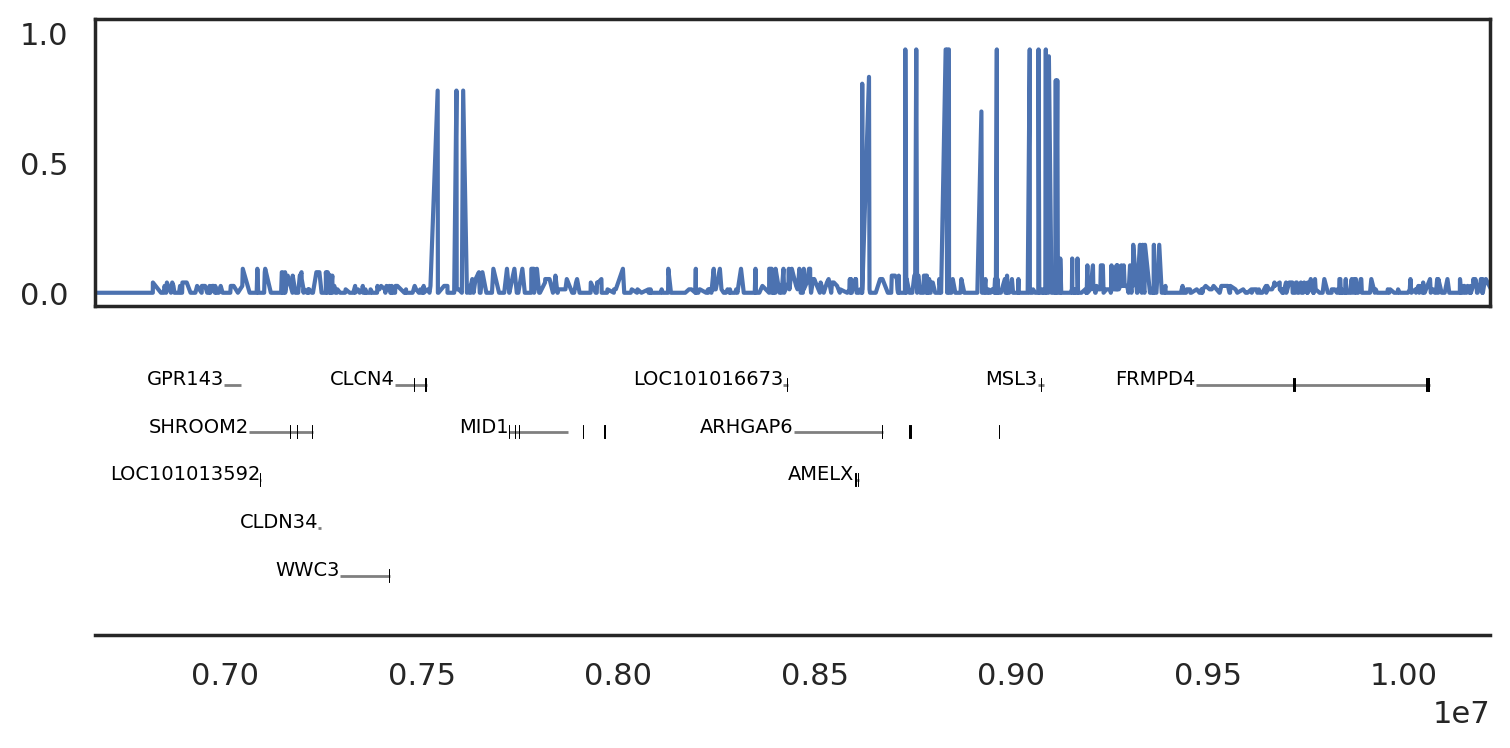

In [64]:
ax = gi.gene_plot('chrX', 7000000, 10000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(mikumi_ns.index, mikumi_ns.north)